# PyTorch Tutorial 

This tutorial is a demo to show how to use PyTorch to train network for digital recognize with MNIST as datasets.


## 1. import packages

In [1]:
%matplotlib inline
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tnrange, tqdm_notebook
import math

## 2. GPU Setting

### 2.1 check out if your cumputer support GPU

In [2]:
use_cuda = torch.cuda.is_available()
if (use_cuda):
    print("Great, you have a GPU!")
else:
    print("Life is short -- consider a GPU!")

Great, you have a GPU!


### 2.2 set a special variable 'device' 

The 'device' variable denotes what device will the cumpute going on.
- If your device has a GPU than, all your compute will be on GPU.
- In later code, It will use the function '.to()' to tell PyTorch which device will the compute going on.
- It use 'cuda:X' to select the Xth GPU.
- And you can ues 'cuda',if you don't care about GPU.
- To know the information about your gpu, use 'nvidia-smi'.

In [3]:
device = torch.device("cuda:2" if use_cuda else "cpu")
print('Your device will be: ', device)  

Your device will be:  cuda:2


## 3. Perpare Datasets

### 3.1 get your dataset 

In this function, you will perpare all your dataset, including data preprocess, data augmentaion and so on.

The following code use PyTorch's datasets directly. You will see that the demo use the MNIST provided by PyTorch so that we can push the demo quickly.

The function 'transforms' is used for preprocessing and you use some funtion for data augmentaion.

In 'transform':
    - the 'ToTensor()' will transform the picture to Tensor and scale the value to range 0.0 to 1.0.
    - the 'Normalize()' will normalize the picture to range -1.0 to 1.0.

See more information in the [offical docs](https://pytorch.org/docs/stable/torchvision/transforms.html)
    
Than we use 'torchvision.datasets.MNIST' to get the dataset and with the parameter 'transform' we can preprocess dataset. When the parameter 'download' equals to 'True' the PyTorch will download the dataset from internet to 'root'.

In [4]:
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_data = torchvision.datasets.MNIST(
    './mnist', train = True, 
    transform = transform,
    download = False
)
test_data = torchvision.datasets.MNIST(
    './mnist', train = False, 
    transform = transform
)

You can check the size of your dataset using '.size()'.

In [14]:
print("train_data:", type(train_data.train_data))
print("train_labels:", type(train_data.train_labels))
print("test_data:", test_data.test_data.size())
print(dir(train_data))

train_data: <class 'torch.Tensor'>
train_labels: <class 'torch.Tensor'>
test_data: torch.Size([10000, 28, 28])
['__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', 'download', 'processed_folder', 'raw_folder', 'root', 'target_transform', 'test_file', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'urls']


### 3.2 prepare dataloader

DataLoader combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset. The iterator contains datas and labels.

The 'batch_size' and 'shuffle' is easily understand.



In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=64, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=64)

### 3.3 visualize data

Let us creat a function to easily show images.

The 'torchvision.utils.make_grid' help us create a grid to show images.

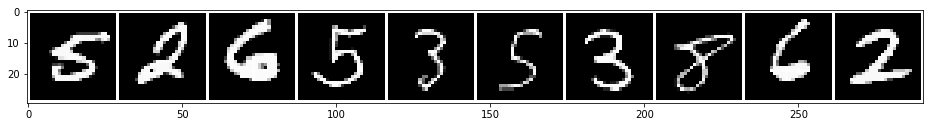

In [7]:
# dataiter = iter(train_loader)
# data,target = dataiter.next()

def imshow(batch, class_names=None, num_images=4):
    plt.figure(figsize=(1.7 * num_images, 1.7))
    img, classes = batch
    
    img_num = min(num_images, img.shape[0])

    grid = torchvision.utils.make_grid(img[:img_num], 
                                       nrow=img_num, 
                                       padding = 1,
                                      pad_value = 1)
    grid = grid.cpu().numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    
    plt.imshow(grid)
    
    if class_names:
        titles = [class_names[x] for x in classes[:img_num]]
        plt.axis('off')
        plt.title(titles)
    plt.pause(0.001)
    
imshow(next(iter(train_loader)), num_images=10)   

In [8]:
torch.manual_seed(117) ## random seed, use prime number.

## 4 Create own Network

### 4.1 create own module

The module consists of two parts, layers and the forward method.

To build your own layers, you need to use servral functions like 'Conv2d', 'Linear', 'MaxPool2d', 'BatchNorm2d' and so on. In order to give you a quick demo, I just list some of them and you will find more information in [offical docs](https://pytorch.org/docs/stable/nn.html). **Don't forget init your layers' values.**

1. 'Conv2d':
    - definition:
        
        `class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)`

    - There are some parameters:
    
        - in_channels (int): Number of channels in the input image
        - out_channels (int): Number of channels produced by the convolution
        - kernel_size (int or tuple): Size of the convolving kernel
        - stride (int or tuple, optional): Stride of the convolution. Default: 1
        - padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        - dilation (int or tuple, optional): Spacing between kernel elements. Default: 1
        - groups (int, optional): Number of blocked connections from input channels to output channels. Default: 1
        - bias (bool, optional): If True, adds a learnable bias to the output. Default: True
        
2. 'Linear':
    - definition:
        
        `CLASS torch.nn.Linear(in_features, out_features, bias=True)`
        
    - parameters:
    
        - in_features: size of each input sample
        - out_features: size of each output sample
        - bias: If set to False, the layer will not learn an additive bias. Default: True
        
3. 'MaxPool2d':
    - definition:
        
        `CLASS torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)`
        
    - parameters:
    
        - kernel_size: the size of the window to take a max over
        - stride: the stride of the window. Default value is kernel_size
        - padding: implicit zero padding to be added on both sides
        - dilation: a parameter that controls the stride of elements in the window
        - return_indices: if True, will return the max indices along with the outputs. Useful for torch.nn.MaxUnpool2d later
        - ceil_mode: when True, will use ceil instead of floor to compute the output shape
        
4. 'BatchNorm2d':
     - definition:
         
         `CLASS torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)`
         
     - parmaters:
         
        - num_features: CC from an expected input of size (N, C, H, W)(N,C,H,W)
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: the value used for the running_mean and running_var computation. Can be set to None for cumulative moving - average (i.e. simple average). Default: 0.1
        - affine: a boolean value that when set to True, this module has learnable affine parameters. Default: True
        - track_running_stats: a boolean value that when set to True, this module tracks the running mean and variance, and - - when set to False, this module does not track such statistics and always uses batch statistics in both training and - eval modes. Default: True
        
Now you have all the informations, Let's build a vgg module.

**Notice, I will change some parmeters against standed vgg module.**

    1. The first convolution layers's `in_channal`. As you know MNIST is just 1 * 28 * 28, It's 1 channel image, and we use MNIST to train our network, of course, will implement to digit recegnization.
    2. We just want to classficate 10 kinds of digit, so the output layer's dimension will ended as 10.



In [9]:
class Net(nn.Module):
    def __init__(self, features, num_classes=10, init_weights=True):
        super(Net, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
#         print('x1: ', x.size())
#         print('x.size(0): ',x.size(0))
        x = x.view(x.size(0), -1)
#         print('x2: ', x.size())
        assert( x.size() == (64,512))
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

vgg16 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
VGG11 = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers) 


## 5. How To Train?

To define our own train function, we need to seprate several part:
    1. some informations about this epoch.
    2. data preparing.
    3. optimizer preparing.
    4. forward and backward.
    5. lost function.
    6. show some train information.
    7. show loss and acc Analysis image.

In [10]:
def train(model, device, train_loader, optimizer, epoch):
    print('epoch: {}'.format(epoch))
    model.train()
    train_loss = 0
    correct = 0
    train_list = {'loss':[],'acc':[],'idx':[]}
    for batch_idx, (inputs, targets) in enumerate(tqdm_notebook(train_loader,total=len(train_loader))):
        
        indx_target = targets.clone() # clone labels
        inputs, targets = Variable(inputs), Variable(targets)
        if use_cuda:
            inputs, targets = inputs.to(device), targets.to(device)
            
        optimizer.zero_grad() # Clears the gradients of all optimized
#         print(inputs.size())
        outputs = model(inputs) # output will be batch_size * class_size 
        
        loss = F.cross_entropy(outputs, targets) 
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        
        if batch_idx % 20 == 0 and batch_idx >= 0:
                pred = outputs.data.max(1)[1]  # get the index of the max log-probability
                correct = pred.cpu().eq(indx_target).sum()
                acc = float(correct) * 1.0 / len(inputs)
                train_list['loss'].append(loss.data.item())
                train_list['acc'].append(acc)
                train_list['idx'].append(batch_idx)
                print('Train Epoch: {} [{:5}/{:5}] Loss: {:.6f} Acc: {:.4f} lr: {:.2e}'.format(
                    epoch, batch_idx * len(inputs), len(train_loader.dataset),
                    loss.data.item(), acc * 100, optimizer.param_groups[0]['lr']))
        
#     print(train_list['loss'],train_list['idx'])
    # losss pic 
    plt.plot(train_list['idx'],
             train_list['loss'],
             "b",linewidth=1,
             label = "epoch_" + str(epoch))   #在当前绘图对象绘图（X轴，Y轴，蓝色虚线，线宽度）
    plt.xlabel("iterations") #X轴标签
    plt.ylabel("loss")  #Y轴标签
    plt.title("Lost Analysis") #图标题
    plt.show()
    
    #acc pic
    plt.plot(train_list['idx'],
             train_list['acc'],
             "r",linewidth=1,
             label = "epoch_" + str(epoch))   #在当前绘图对象绘图（X轴，Y轴，蓝色虚线，线宽度）
    plt.xlabel("iterations") #X轴标签
    plt.ylabel("acc")  #Y轴标签
    plt.title("Accuracy Analysis") #图标题
    plt.show()

In [11]:
def test(model, device, test_loader, optimizer, epoch):
    model.eval()
    
    test_loss = 0
    correct = 0
    global best_acc
    
    for inputs, target in tqdm_notebook(test_loader,total=len(test_loader)):
        indx_target = target.clone()
        
        target = Variable(target)
        with torch.no_grad():
            inputs = Variable(inputs)
        
        if use_cuda:
            inputs, target = inputs.to(device), target.to(device)
            
        output = model(inputs)
        
        test_loss += F.cross_entropy(output, target).data.item()
        pred = output.data.max(1)[1]  # get the index of the max log-probability
        correct += pred.cpu().eq(indx_target).sum()
        test_loss_percent = test_loss / len(test_loader) # average over number of mini-batch
        acc = 100. * correct / len(test_loader.dataset)
        
#         print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
#             test_loss_percent, correct, len(test_loader.dataset), acc))
        
    
        # model save
        if acc > best_acc:
            best_acc = acc
            save_file = 0
            if save_file:
                new_file = os.path.join(args.logdir, 'best-{}.pth'.format(epoch))
                misc.model_snapshot(model, new_file, old_file=old_file, verbose=True)
                old_file = new_file
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
    test_loss * 100 / len(test_loader), correct, len(test_loader.dataset), acc))

In [12]:
print(VGG11)
model = Net(make_layers(VGG11,batch_norm = True))
if use_cuda:
    model.to(device)
print(model)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

[64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
Net(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
best_acc = 0;
try:
    epoch_size = 1
    for epoch in range(epoch_size):
        train(model,device,train_loader,optimizer,epoch)
        test(model,device,test_loader,optimizer,epoch)
        torch.cuda.empty_cache()
except Exception as e:
    import traceback
    traceback.print_exc()
finally:
    print("Best Result: {:.3f}%".format(best_acc))